<a href="https://colab.research.google.com/github/linggaajiandika/tensorflow_image_processing/blob/master/Workshop_Tensorflow_World_Extended_Semarang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workshop Tensorflow World Extended Semarang**


## Convolutional Neural Networks: Image Classification & Predicting

### Import Python Package

In [0]:
# tensorflow & keras
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,MaxPooling2D,AveragePooling2D
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam,SGD,Adagrad,RMSprop

#keperluan plot
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

#Explore data & Directory
import pandas as pd
import numpy as np
import os
from google.colab import files
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
print(tf.__version__)

1.15.0


In [11]:
#upgrade ke tensorflow 2
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


### Load Dataset


In [13]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
#Sumber
source = data_dir
# Destinasi
destination = '/content'
 # Pindahkan folder
data_dir = shutil.move(source, destination) 

228818944/228813984 [==============================] - 2s 0us/step


### Explore data gambar

Explore data gambar disini bertujuan untuk mengetahui kode warna dari gmabar dan banyaknya data / kode warna yang ada di suatu gambar (sebagai contoh data yang akan diolah di CNN), Gambar berwarna merupakan perpaduan dari 3 warna primer yaitu red,green, dan blue (RGB). Semua warna RGB diperlukan sebagai input layer pada saat pembangunan model CNN

Text(0.5, 1.0, 'gambar resize')

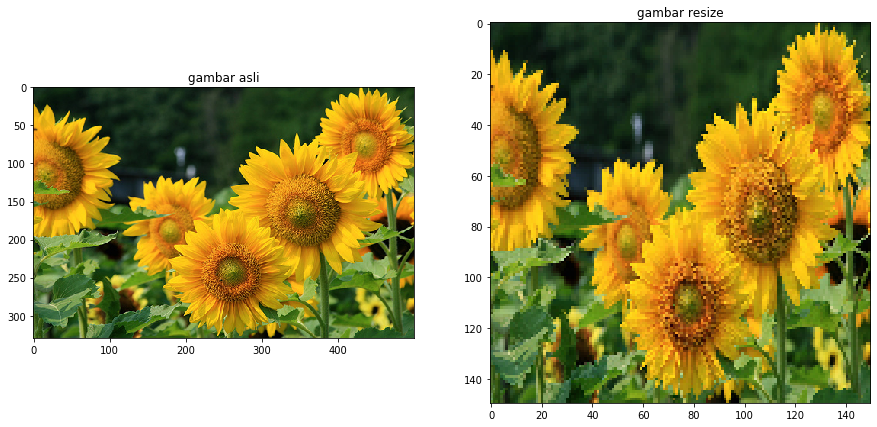

In [14]:
img = Image.open('/content/flower_photos/sunflowers/1008566138_6927679c8a.jpg')
imgrez=img.resize((150,150))
fig = plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("gambar asli")
plt.subplot(1,2,2)
plt.imshow(imgrez)
plt.title("gambar resize")

In [18]:
import matplotlib.image as mpimg
img =mpimg.imread('/content/flower_photos/sunflowers/1008566138_6927679c8a.jpg')
print("original image:")
print('Type of the image : ' , type(img))
print('Image size {}'.format(img.size))
print('Shape of the image : {}'.format(img.shape))
print('Image Height {}'.format(img.shape[0]))
print('Image Width {}'.format(img.shape[1]))
print('Dimension of Image {}'.format(img.ndim))

original image:
Type of the image :  <class 'numpy.ndarray'>
Image size 495000
Shape of the image : (330, 500, 3)
Image Height 330
Image Width 500
Dimension of Image 3


In [19]:
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min()))

Maximum RGB value in this image 255
Minimum RGB value in this image 0


In [21]:
print("original image:")
print('Value of only R channel {}'.format(img[ 0, 0, 2]))
print('Value of only G channel {}'.format(img[ 0, 0, 1]))
print('Value of only B channel {}'.format(img[ 0, 0, 0]))

original image:
Value of only R channel 42
Value of only G channel 49
Value of only B channel 34


In [22]:
usecols=[0,1,2,3,4]
print('R Channel Only')
redcol=img[ :, :, 2]
np.savetxt("redcol.csv", redcol, delimiter=",")
dfred = pd.read_csv("redcol.csv",header=None, usecols=usecols)
pd.options.display.float_format = '{:,.0f}'.format
dfred.head()

R Channel Only


,0,1,2,3,4
0,42,39,39,40,39
1,40,37,37,39,39
2,38,35,36,38,39
3,33,32,35,38,37
4,30,31,32,34,35


In [24]:
print('G Channel Only')
grcol=img[ :, :, 1]
np.savetxt("grcol.csv", grcol, delimiter=",")
dfgreen = pd.read_csv("grcol.csv",header=None, usecols=usecols)
pd.options.display.float_format = '{:,.0f}'.format
dfgreen.head()

G Channel Only


,0,1,2,3,4
0,49,49,51,52,51
1,48,47,49,51,51
2,46,45,48,50,50
3,44,44,47,51,50
4,42,44,48,50,48


In [25]:
print('B Channel Only')
blcol=img[ :, :, 0]
np.savetxt("bluecol.csv", blcol, delimiter=",")
dfblue = pd.read_csv("bluecol.csv",header=None, usecols=usecols)
pd.options.display.float_format = '{:,.0f}'.format
dfblue.head()

B Channel Only


,0,1,2,3,4
0,34,33,33,34,33
1,31,30,31,33,31
2,29,28,28,30,30
3,24,24,27,29,28
4,22,22,25,27,26


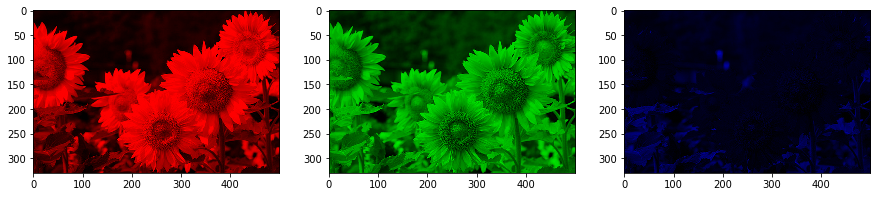

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), ax):
    
    # create zero matrix
    split_img = np.zeros(img.shape, dtype="uint8") # 'dtype' by default: 'numpy.float64'
    
    # assing each channel 
    split_img[ :, :, c] = img[ :, :, c]
    
    # display each channel
    ax.imshow(split_img)

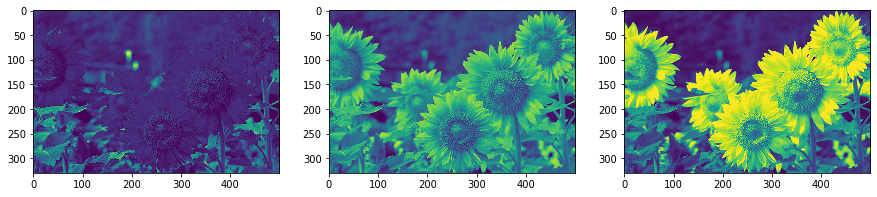

In [27]:
#Contrast dari gambar
fig = plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(img[ : , : , 2])
plt.subplot(1,3,2)
plt.imshow(img[ : , : , 1])
plt.subplot(1,3,3)
plt.imshow(img[ : , : , 0])


### Preprocessing data

Split data dengan membagi menjadi training, validasi, test (hanya klasifikasi dandelion & sunflowers)

Pembagian data biasanya menerapkan perbandingan 70:15:15 (train:validasi:train) tapi untuk kasus deep learning tidak mensyaratkan harus 70:15:15, bergantung pada kondisi data

Data training: berfungsi untuk melatih model
Data Validasi : berfungsi memvalidasi model
Data test: berfungsi untuk mengetahui seberapa baik model bekerja

In [0]:
sun_dir= os.listdir('flower_photos/sunflowers')
rose_dir= os.listdir('flower_photos/roses')

In [0]:
sun_train,sun_test = train_test_split(sun_dir, test_size=0.2, random_state=1)
sun_test, sun_val = train_test_split(sun_test, test_size=0.5, random_state=1)

rose_train, rose_test = train_test_split(rose_dir, test_size=0.2, random_state=1)
rose_test, rose_val = train_test_split(rose_test, test_size=0.5, random_state=1)

In [30]:
print("sunflower training data: " + str(len(sun_train)))
print("sunflower training data: "+ str(len(rose_train)))
print('')
print("sunflower validation data: "+ str(len(sun_val)))
print("sunflower validation data: "+str(len(rose_val)))
print('')
print("sunflower test data: "+str(len(sun_test)))
print("sunflower test data: "+str(len(rose_test)))

sunflower training data: 559
sunflower training data: 512

sunflower validation data: 70
sunflower validation data: 65

sunflower test data: 70
sunflower test data: 64


In [0]:
# Membuat directory atau folder pemisah gambar
os.makedirs('data/train/sun')
os.makedirs('data/train/rose')

os.makedirs('data/test/sun')
os.makedirs('data/test/rose')

os.makedirs('data/val/sun')
os.makedirs('data/val/rose')

In [0]:
#Memidahkan secara otomatis list gambar ke folder masing2 tanpa manual

#train
for f in sun_train:
  shutil.move('flower_photos/sunflowers/'+f, 'data/train/sun')
for f in rose_train:
  shutil.move('flower_photos/roses/'+f, 'data/train/rose')


In [0]:
#val

for f in sun_val:
  shutil.move('flower_photos/sunflowers/'+f, 'data/val/sun')
for f in rose_val:
  shutil.move('flower_photos/roses/'+f, 'data/val/rose')


In [0]:
# test
for f in sun_test:
  shutil.move('flower_photos/sunflowers/'+f, 'data/test/sun')
for f in rose_test:
  shutil.move('flower_photos/roses/'+f, 'data/test/rose')

In [0]:
train_dir = os.path.join('/content/data/train')
val_dir = os.path.join('/content/data/val')
test_dir = os.path.join('/content/data/test')

### Generate data


pada proses ini semua gambar diubah ke dalam array, seperti pada saat explore data, hanya saja dilakukan untuk semua gambar dan secara otomatis

untuk data training, agar memperbanyak data training maka diperlukan manipulasi data dengan data augmentasi, yaitu memodifikasi data dengan berbagai cara seperti merotasi, membalik dan menggeser gambar

In [36]:
image_size = 224 # Semua gambar diubah kedalam 224 *224
batch_size = 32

# ubah semua kode gambar dari 0-255 menjadi 0-1 (berfungsi untuk standarisasi dari data)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)
                # featurewise_center=True,
                # featurewise_std_normalization=True,
                # rotation_range=20,
                # width_shift_range=0.2,
                # height_shift_range=0.2,
                # horizontal_flip=True)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

# Generate data gambar menjadi array
train_generator = train_datagen.flow_from_directory(
                train_dir,  
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
                val_dir, 
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')


test_generator = test_datagen.flow_from_directory(
                test_dir, 
                target_size=(image_size, image_size),
                batch_size=batch_size,
                shuffle=False, #mempermudah saat nanti klasifikasi mengunakan sklearn
                class_mode='binary')

Found 1071 images belonging to 2 classes.
Found 135 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [37]:
len(os.listdir('/content/data/val/rose'))

65

### Build Model

Model CNN dilakukan dengan memilih2, karena tidak ada kepastian bagaiman arsitektur model mampu meningkatkan akurasi

pada kasus ini model dibangun secara sederhana tanpa melibatkkan arsitektur seperti MobileNetV2 dkk

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(224, 224, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Early stopping dibutuhkan ketika epochs mulai konvergen tetapi belum mencapai batas epochs maksimal
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="auto") 

model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=['BinaryAccuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


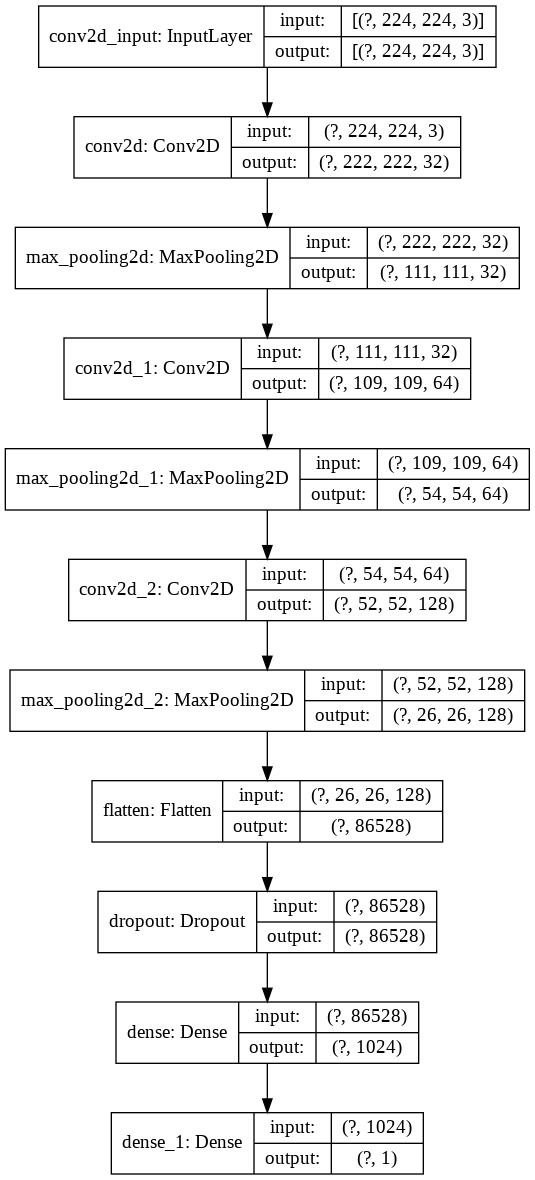

In [39]:
#Plot model
keras.utils.plot_model(model, "arsitektur_model.png", show_shapes=True)

In [40]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,validation_data=validation_generator,
                              epochs=epochs,shuffle=False)

Epoch 1/10
33/33 [==============================] - 14s 417ms/step - loss: 2.0360 - binary_accuracy: 0.7093 - val_loss: 0.8784 - val_binary_accuracy: 0.9259
Epoch 2/10
33/33 [==============================] - 7s 202ms/step - loss: 0.7358 - binary_accuracy: 0.8758 - val_loss: 0.5551 - val_binary_accuracy: 0.9259
Epoch 3/10
33/33 [==============================] - 6s 196ms/step - loss: 0.4904 - binary_accuracy: 0.8884 - val_loss: 0.4330 - val_binary_accuracy: 0.9185
Epoch 4/10
33/33 [==============================] - 6s 197ms/step - loss: 0.3730 - binary_accuracy: 0.8999 - val_loss: 0.3798 - val_binary_accuracy: 0.9111
Epoch 5/10
33/33 [==============================] - 6s 197ms/step - loss: 0.3142 - binary_accuracy: 0.9076 - val_loss: 0.3751 - val_binary_accuracy: 0.8963
Epoch 6/10
33/33 [==============================] - 7s 200ms/step - loss: 0.2907 - binary_accuracy: 0.9143 - val_loss: 0.3186 - val_binary_accuracy: 0.9333
Epoch 7/10
33/33 [==============================] - 7s 203ms/st

In [41]:
acc = history.history['BinaryAccuracy']
val_acc =history.history['val_BinaryAccuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy',color='b', linewidth= 2)
plt.plot(val_acc, label='Validation Accuracy',color='r', linewidth= 2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',color='b', linewidth= 2)
plt.plot(val_loss, label='Validation Loss',color='r', linewidth= 2)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-d843cee3bdbe>", line 1, in <module>
    acc = history.history['BinaryAccuracy']
KeyError: 'BinaryAccuracy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.

KeyError: ignored

### Test data: Classification

In [42]:
#Test data
model.evaluate(test_generator)
pred=model.predict_classes(test_generator,batch_size=None)
y_pred=np.array([0]*70+[1]*64)

5/5 [==============================] - 1s 170ms/step - loss: 0.2313 - binary_accuracy: 0.9328


In [43]:
# Confusion Matrix
target_names = ['sunflowers','roses']
print(classification_report(y_pred,pred, target_names=target_names))

              precision    recall  f1-score   support

  sunflowers       0.92      0.86      0.89        70
       roses       0.86      0.92      0.89        64

    accuracy                           0.89       134
   macro avg       0.89      0.89      0.89       134
weighted avg       0.89      0.89      0.89       134



Confusion matrix, without normalization
[[60 10]
 [ 5 59]]


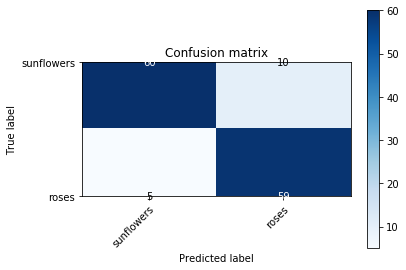

In [44]:
# Klasifikasi data test
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[:2]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_pred, pred, classes=['sunflowers','roses'],
                      title='Confusion matrix')

plt.show()

### Test Data: Predicting

In [45]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(fn)
  print(classes)

Saving 523682.jpg to 523682.jpg
523682.jpg
[[0.]]
